In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import keras
import os
import zipfile
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
ls

CNN_malaria.keras  drive/  malaria_dataset/  sample_data/


In [3]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/malaria_hematie_dataset.zip'

extract_path = '/content/malaria_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

['malaria_hematie_dataset']


In [4]:
infected_dir = '/content/malaria_dataset/malaria_hematie_dataset/parasitized'
uninfected_dir = '/content/malaria_dataset/malaria_hematie_dataset/uninfected'

count_infected = len(os.listdir(infected_dir))
count_uninfected = len(os.listdir(uninfected_dir))

print(f"Nombre d'images infectées : {count_infected}, Nombre d'images non infectées: {count_uninfected}")

Nombre d'images infectées : 13779, Nombre d'images non infectées: 13779


Analyse des données :
Les classes sont équilibrées , pas besoin de faire de la data augmentation


In [6]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    rescale=1/255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/malaria_dataset/malaria_hematie_dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    '/content/malaria_dataset/malaria_hematie_dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [7]:
unique_train, counts_train = np.unique(train_generator.classes, return_counts=True)

print(f"Classes detectées pour train {unique_train}, valeurs detectées par classees  {counts_train}")


unique_val, counts_val = np.unique(val_generator.classes, return_counts=True)

print(f"Classes detectées pour validation {unique_val}, valeurs detectées par classees  {counts_val}")

Classes detectées pour train [0 1], valeurs detectées par classees  [11024 11024]
Classes detectées pour validation [0 1], valeurs detectées par classees  [2755 2755]


Conclusion classes even dans train et val apres split.

In [14]:
print(train_generator.image_shape)
print(val_generator.image_shape)

(128, 128, 3)
(128, 128, 3)


In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3),padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.3),
    layers.Dense(64, activation='relu'),
    Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


model.compile(
    optimizer="adamw",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,296,001 (16.39 MB)

 Trainable params: 4,296,001 (16.39 MB)

 Non-trainable params: 0 (0.00 B)

3 couches de convolution commençant par 32 noyaux, en doublant à chaque couche (32 → 64 → 128), avec un padding 'same'.
ReLU comme fonction d'activation pour permettre de capturer des relations non linéaires.
Shape d'entrée de 224×224×3 : 224×224 comme défini dans le générateur de données, et 3 pour les 3 canaux de couleur RGB.
Utilisation de la loss function binary_crossentropy pour la classification binaire entre 2 catégories (parasitized et uninfected).
Utilisation de l'optimizer Adam pour minimiser l'erreur lors de l'entraînement.

In [16]:

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Callback pour sauvegarde du meilleur modèle
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="CNN_malaria.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1000,
    verbose = 1,
    callbacks=[checkpoint_callback, early_stopping],
    )


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7479 - loss: 0.5054
Epoch 1: val_accuracy improved from -inf to 0.95318, saving model to CNN_malaria.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 147s 203ms/step - accuracy: 0.7481 - loss: 0.5052 - val_accuracy: 0.9532 - val_loss: 0.1538
Epoch 2/1000
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9539 - loss: 0.1628
Epoch 2: val_accuracy improved from 0.95318 to 0.95662, saving model to CNN_malaria.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 138s 200ms/step - accuracy: 0.9539 - loss: 0.1628 - val_accuracy: 0.9566 - val_loss: 0.1374
Epoch 3/1000
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9548 - loss: 0.1476
Epoch 3: val_accuracy did not improve from 0.95662
689/689 ━━━━━━━━━━━━━━━━━━━━ 133s 194ms/step - accuracy: 0.9548 - loss: 0.1476 - val_accuracy: 0.9566 - val_loss: 0.1332
Epoch 4/1000
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9545 - loss: 0.1461
Epoch 4: val_accuracy improved from 0.95662 to 0.

Found 5510 images belonging to 2 classes.
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9538 - loss: 0.1219
Loss: 0.1227, Accuracy: 0.9597
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step


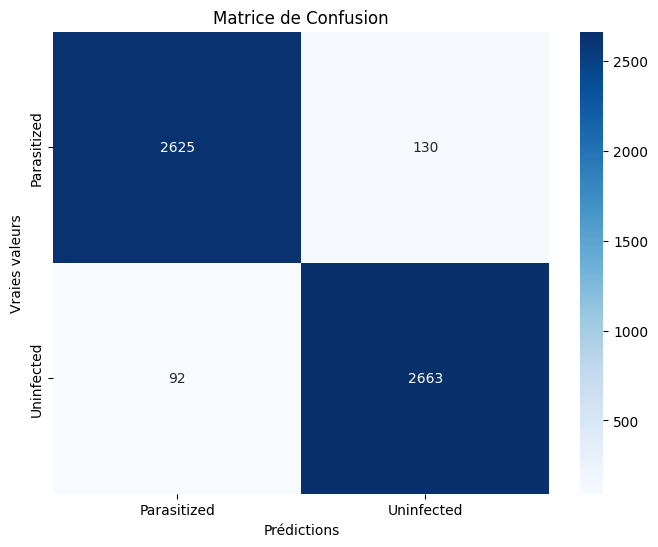


Précision : 0.9535 (95.35%)
Rappel    : 0.9666 (96.66%)
F1-score  : 0.9600 (96.00%)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

datagen_test = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

val_generator_test = datagen_test.flow_from_directory(
    '/content/malaria_dataset/malaria_hematie_dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

loss, accuracy = model.evaluate(val_generator_test)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(val_generator_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = val_generator_test.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Parasitized", "Uninfected"],
            yticklabels=["Parasitized", "Uninfected"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nPrécision : {precision:.4f} ({precision*100:.2f}%)")
print(f"Rappel    : {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-score  : {f1:.4f} ({f1*100:.2f}%)")
